# Fix Seed

In [1]:
import random
import torch
import numpy as np

# 시드 고정 함수 정의
def seed_everything(seed=5):
    # Python의 기본 random 모듈 시드 설정
    random.seed(seed)
    
    # NumPy의 난수 생성 시드 설정
    np.random.seed(seed)
    
    # PyTorch의 CPU 난수 생성 시드 설정
    torch.manual_seed(seed)
    
    # CUDA가 사용 가능한 경우 GPU 난수 생성 시드 설정
    if torch.cuda.is_available():
        # 현재 GPU 장치에 대한 시드 설정
        torch.cuda.manual_seed(seed)
        # 모든 GPU 장치에 대한 시드 설정
        torch.cuda.manual_seed_all(seed)

    # PyTorch의 CuDNN 설정을 통해 재현성을 보장
    # CuDNN이 제공하는 최적화가 정확하게 재현될 수 있도록 보장
    torch.backends.cudnn.deterministic = True  # 고정된 알고리즘만 사용하도록 설정
    torch.backends.cudnn.benchmark = False  # 입력 크기가 고정된 경우 최적화 비활성화

seed_everything()

# Dataset

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, dir_paths, transform=None):
        self.images = []
        self.labels = []
        self.transform = transform

        for dir_path in dir_paths:
            label = os.path.basename(dir_path) # 'cat' 또는 'dog'
            for file_name in os.listdir(dir_path):
                image_path = os.path.join(dir_path, file_name)
                image = Image.open(image_path).convert('RGB')
                if self.transform:
                    image = self.transform(image)
                self.images.append(image)
                self.labels.append(label)
                
        # 레이블 인코딩
        self.label_to_index = {'cat': 0, 'dog': 1}
        self.labels = [self.label_to_index[label] for label in self.labels]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = image.float() / 255.0  # Normalize to [0, 1]

        return image, label


In [3]:
from torchvision import transforms

# 데이터 전처리 정의
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),  # 이미지를 [0, 1] 범위로 정규화
])

# 디렉터리 경로
cat_dir = '../data/cifar10_images/cat'
dog_dir = '../data/cifar10_images/dog'

# Custom Dataset 인스턴스 생성
dataset = CustomDataset(dir_paths=[cat_dir, dog_dir], transform=transform)

# 데이터셋을 학습용, 검증용, 테스트용으로 분리
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

# DataLoader 인스턴스 생성
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 데이터 확인
for images, labels in train_loader:
    print(f"학습 배치 이미지 크기: {images.size()}")
    print(f"학습 배치 레이블 크기: {labels.size()}")
    break

for images, labels in valid_loader:
    print(f"검증 배치 이미지 크기: {images.size()}")
    print(f"검증 배치 레이블 크기: {labels.size()}")
    break

for images, labels in test_loader:
    print(f"테스트 배치 이미지 크기: {images.size()}")
    print(f"테스트 배치 레이블 크기: {labels.size()}")
    break

학습 배치 이미지 크기: torch.Size([16, 3, 32, 32])
학습 배치 레이블 크기: torch.Size([16])
검증 배치 이미지 크기: torch.Size([16, 3, 32, 32])
검증 배치 레이블 크기: torch.Size([16])
테스트 배치 이미지 크기: torch.Size([16, 3, 32, 32])
테스트 배치 레이블 크기: torch.Size([16])


# HyperParameter

In [4]:
# 하이퍼파라미터 설정
input_size = 32 * 32 * 3  # 이미지 크기 (32x32) x 3 채널
hidden_size = 128
learning_rate = 0.0001
num_epochs = 100

# Weight Initalize

In [5]:
import torch.nn as nn

# 가중치 초기화
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Model

In [6]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.apply(weights_init)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

model = SimpleNN(input_size=input_size, hidden_size=hidden_size)

In [7]:
def count_parameters(model):
    """
    모델의 파라미터 수를 계산하는 함수
    """
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

def print_model_parameters(model):
    """
    모델의 각 레이어와 그 파라미터 수를 출력하는 함수
    """
    for name, param in model.named_parameters():
        print(f"{name}: {param.numel()} parameters")
    print(f"Total parameters: {count_parameters(model)}")

# 모델의 파라미터 수 출력
print_model_parameters(model)

fc1.weight: 393216 parameters
fc1.bias: 128 parameters
fc2.weight: 128 parameters
fc2.bias: 1 parameters
Total parameters: 393473


# Loss

$
\begin{align}
-\frac{1}{N}\sum_{i=1}^N[y_ilog(p_i)+(1-y_i)log(1-p_i)]
\end{align}
$

1. 선형 모델의 출력: [0.5, -1.2, 0.8]
2. Sigmoid의 출력: [0.62245933, 0.23147522, 0.68997448]
3. 실제 레이블: [1, 0, 1]

In [8]:
# 이진 크로스 엔트로피 손실 함수
# 모델의 예측 확률과 실제 레이블 간의 차이를 측정하여, 예측이 정확할수록 손실을 줄이는 방향으로 모델을 학습시킵니다.
criterion = nn.BCELoss()  # Binary Cross Entropy Loss

# Optimizer

In [9]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train

Epoch 1/100, Loss: 0.6932
Epoch 1/100, Validation Loss: 0.6934
Epoch 2/100, Loss: 0.6927
Epoch 2/100, Validation Loss: 0.6926
Epoch 3/100, Loss: 0.6925
Epoch 3/100, Validation Loss: 0.6927
Epoch 4/100, Loss: 0.6922
Epoch 4/100, Validation Loss: 0.6929
Epoch 5/100, Loss: 0.6916
Epoch 5/100, Validation Loss: 0.6918
Epoch 6/100, Loss: 0.6912
Epoch 6/100, Validation Loss: 0.6914
Epoch 7/100, Loss: 0.6910
Epoch 7/100, Validation Loss: 0.6910
Epoch 8/100, Loss: 0.6903
Epoch 8/100, Validation Loss: 0.6911
Epoch 9/100, Loss: 0.6900
Epoch 9/100, Validation Loss: 0.6904
Epoch 10/100, Loss: 0.6894
Epoch 10/100, Validation Loss: 0.6901
Epoch 11/100, Loss: 0.6889
Epoch 11/100, Validation Loss: 0.6899
Epoch 12/100, Loss: 0.6884
Epoch 12/100, Validation Loss: 0.6897
Epoch 13/100, Loss: 0.6882
Epoch 13/100, Validation Loss: 0.6893
Epoch 14/100, Loss: 0.6875
Epoch 14/100, Validation Loss: 0.6885
Epoch 15/100, Loss: 0.6871
Epoch 15/100, Validation Loss: 0.6868
Epoch 16/100, Loss: 0.6872
Epoch 16/100, Va

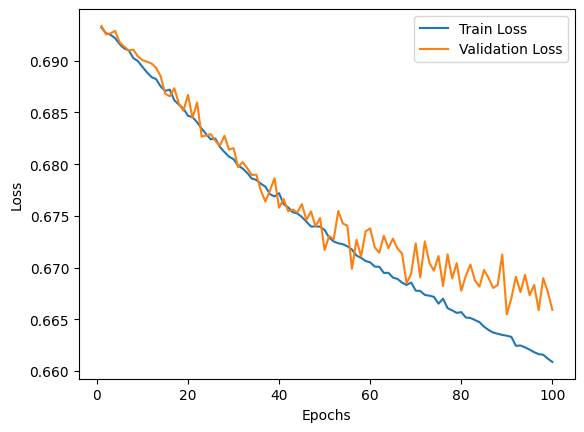

In [10]:
import matplotlib.pyplot as plt

# 학습 및 검증 손실을 저장할 리스트 초기화
train_losses = []
valid_losses = []

# 학습 루프 시작
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0  # 에폭 동안의 총 손실을 저장할 변수

    for images, labels in train_loader:
        # 모델에 입력하기 위해서 이미지를 (32, 32, 32, 3) 크기에서 (32, 3072)로 변형
        images = images.view(images.size(0), -1)

        # 레이블을 float형으로 변환하고 (batch_size,) 모양을 (batch_size, 1)로 변형
        # BCE 손실 함수는 레이블이 float형이어야 함
        labels = labels.float().view(-1, 1)

        # 순전파(Forward pass): 모델에 입력 데이터를 통과시켜 예측값을 얻음
        outputs = model(images)

        # 손실 함수 계산: 모델의 예측값과 실제 레이블 간의 손실을 계산
        loss = criterion(outputs, labels)

        # 역전파(Backward pass) 및 최적화
        optimizer.zero_grad()  # 이전의 기울기(gradient) 값을 초기화
        loss.backward()  # 손실 함수에 대한 기울기를 계산
        optimizer.step()  # 계산된 기울기로 모델 파라미터를 업데이트

        # 배치 손실을 총 손실에 추가
        running_loss += loss.item() * images.size(0)  # .item()은 텐서에서 값을 추출

    # 에폭 당 평균 손실을 계산
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # 에폭이 끝날 때마다 손실 값을 출력
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # 검증 루프 시작
    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.view(images.size(0), -1)
            labels = labels.float().view(-1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)

    val_epoch_loss = val_running_loss / len(valid_loader.dataset)
    valid_losses.append(val_epoch_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_epoch_loss:.4f}')

# 학습 및 검증 손실 시각화
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict

In [11]:
# 모델을 평가 모드로 설정
model.eval()
correct = 0
total = 0

# 평가 중 기울기 계산을 비활성화 (메모리 절약 및 연산 속도 향상)
with torch.no_grad():
    # 테스트 데이터 로더를 통해 배치 단위로 테스트 데이터를 순회
    for images, labels in test_loader:
        # 이미지를 (32x32x3) 크기에서 (3072,)로 변형
        images = images.view(images.size(0), -1)

        # 레이블을 float형으로 변환하고 (batch_size,) 모양을 (batch_size, 1)로 변형
        labels = labels.float().view(-1, 1)

        # 모델에 이미지를 통과시켜 예측값을 얻음
        outputs = model(images)

        # 예측 확률이 0.5보다 크면 1(positive class)로, 그렇지 않으면 0으로 변환
        predicted = (outputs > 0.5).float()

        # 총 샘플 수를 업데이트
        total += labels.size(0)
        # 맞춘 샘플의 수를 업데이트
        correct += (predicted == labels).sum().item()

# 정확도 계산
accuracy = correct / total
# 정확도를 백분율로 출력
print(f"Test Set Accuracy: {accuracy * 100:.2f}%")

Test Set Accuracy: 60.00%
